In [ ]:
# This block imports modules, randomly separates the data into training / validation / test sets, 
# and defines and evaluates the pretrained model

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.version
from torchvision.models import mobilenet_v3_large
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid

# This implementation includes a scipy library to directly read .WAV files and uses TorchAudio for structure and transforms


import os
from scipy.io import wavfile
import torchaudio
import torchaudio.transforms as transforms
import soundfile
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device to GPU if available
#print(torch.version.cuda)
#print(device)

class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # "data/" directory location
        self.file_paths = [] # file path for each data point
        self.labels = [] # list of labels in dataset
        self.transform = transform # transform (if specified - converts to Mel spectrogram in implementation)

        # Walk through directory and collect file paths and labels
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for file_name in os.listdir(label_path):
                    if file_name.endswith(".wav"):
                        self.file_paths.append(os.path.join(label_path, file_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load audio file
        audio_path = self.file_paths[idx]
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to mono if necessary
        if waveform.size(0) > 1:  # Check if stereo
            waveform = waveform.mean(dim=0, keepdim=True)  # Average channels

        # Get class label
        label = self.labels[idx]
        
        # Apply transformation if specified
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform.squeeze(0), label

class AudioDataset_WithPadding(Dataset):
    def __init__(self, root_dir, max_length, transform=None):
        self.root_dir = root_dir # "data/" directory location
        self.file_paths = [] # file path for each data point
        self.labels = [] # list of labels in dataset
        self.max_length = max_length # Uses maximum audio file length found when first loading dataset to determine padding length
        self.transform = transform # transform (if specified - converts to Mel spectrogram in implementation)

        # Import data from files, using path for class folder as label identifier
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for file_name in os.listdir(label_path):
                    if file_name.endswith(".wav"):
                        self.file_paths.append(os.path.join(label_path, file_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load audio file
        audio_path = self.file_paths[idx]
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to mono if necessary
        if waveform.size(0) > 1:  # Check if stereo
            waveform = waveform.mean(dim=0, keepdim=True)  # Average channels

        # Pad waveform to the fixed length
        if waveform.size(1) < self.max_length:
            pad_amount = self.max_length - waveform.size(1)
            #print(pad_amount)
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount), "constant", 0)
        
        # Get class label
        label = self.labels[idx]
        if label == "Major":
            label_num = 0
        else:
            label_num = 1
        
        # Apply transformation if specified
        if self.transform:
            waveform = self.transform(waveform)
            #print(waveform.size(2))

        return waveform, label, label_num


transform = transforms.MelSpectrogram(sample_rate=16000, n_mels=64)

root_dir = "data/"

dataset_temp = AudioDataset(root_dir) # Create dataset from major / minor chords folders (chords are organized in folders by chord type)

waveforms = [dataset_temp[i][0] for i in range(len(dataset_temp))]

max_length = 0
for i, waveform in enumerate(waveforms):
    if (int(waveform.shape[0])) > max_length:
        max_length = int(waveform.shape[0])

dataset = AudioDataset_WithPadding(root_dir, max_length=max_length, transform=transform) # Create dataset from major / minor chords folders (chords are organized in folders by chord type)

waveforms = [dataset[i][0] for i in range(len(dataset))]

data_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle=True) # Load Dataset

for batch in data_loader:
    waveforms, labels, labels_num = batch

num_data = len(dataset) # Total Number of Data Points in Dataset

train_size = int(0.7*num_data) # Allocate 70% of Data Points for Training
val_size = int(0.15*num_data) # Allocate 15% of Data Points for Validation Set
test_size = num_data - train_size - val_size # Allocate Remaining Data Points (15%) for Test Set

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # Use random_split to randomly separate the dataset into training, validation, testing sets

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True) # training data loader with randomization and batch size 10
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False) # validation data loader with no randomization and batch size 10
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False) # test data loader with no randomization and batch size 10

num_class = 2
model_pretrained = mobilenet_v3_large(pretrained=True)
model_pretrained.classifier[3] = nn.Sequential(
    nn.Dropout(0.5), # implement dropout rate of 50% to discourage overfitting
    nn.Linear(model_pretrained.classifier[3].in_features, num_class)
)

model_pretrained.features[0][0] = nn.Conv2d(
    in_channels=1,  # Change to 1 for single-channel input
    out_channels=16,  # Keep the same as original
    kernel_size=3,
    stride=2,
    padding=1,
    bias=False
)

num_major = 0
num_minor = 0

# Get count of major / minor chords in training set

for waveform, label, label_num in train_dataset:
    if label_num == 0:
        num_major += 1
    else:
        num_minor += 1

class_ns = torch.tensor([num_major, num_minor])
weights = 1.0 / class_ns
weights = weights / weights.sum()

criter = nn.CrossEntropyLoss(weight=weights)

model_pretrained.to(device) # move pretrained model to GPU

model_pretrained.eval()

outputs_list = []
correct = 0
total = 0
loss_pretrained = 0
with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        #images, labels = images.to(device), labels.to(device)
        #print(images.shape)
        outputs = model_pretrained(waveforms)
        _, predicted = torch.max(outputs, 1)
        total+= len(labels)
        #batch_labels = []
        for i in range(len(labels_num)):
            if labels_num[i] == predicted[i]:
                correct+=1
        #print(batch_labels)
        #correct+= (predicted == batch_labels).sum().item()
        outputs_list.append(outputs)
        #batch_labels = torch.tensor(batch_labels)
        #print(batch_labels)
        loss = criter(outputs,labels_num)
        loss_pretrained += loss.item() * waveforms.size(0)
        

print("{}% Test Accuracy With Pre-Trained Model".format(correct/total*100))
print("Test Set Loss of {} With Pre-Trained Model".format(loss_pretrained))




C:\Users\sk3ll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sk3ll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


37.69230769230769% Test Accuracy With Pre-Trained Model
Test Set Loss of 93.78467261791229 With Pre-Trained Model


Training Model with Fully Connected (Output) Layer Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.7147130806513515
Training Accuracy After Epoch 1: 52.25%

Validation Loss For Epoch 1: 0.7445121360942721
Validation Accuracy After Epoch 1: 44.53%

Epoch 2/10:

Training Loss For Epoch 2: 0.7132697048877519
Training Accuracy After Epoch 2: 51.25%

Validation Loss For Epoch 2: 0.7308069048449397
Validation Accuracy After Epoch 2: 46.88%

Epoch 3/10:

Training Loss For Epoch 3: 0.7059755052583984
Training Accuracy After Epoch 3: 51.91%

Validation Loss For Epoch 3: 0.7194967931136489
Validation Accuracy After Epoch 3: 49.22%

Epoch 4/10:

Training Loss For Epoch 4: 0.7080540905974669
Training Accuracy After Epoch 4: 52.75%

Validation Loss For Epoch 4: 0.7346090534701943
Validation Accuracy After Epoch 4: 48.44%

Epoch 5/10:

Training Loss For Epoch 5: 0.6849461535050746
Training Accuracy After Epoch 5: 57.90%

Validation Loss For Epoch 5: 0.7457988113164902
Validation Accuracy After 

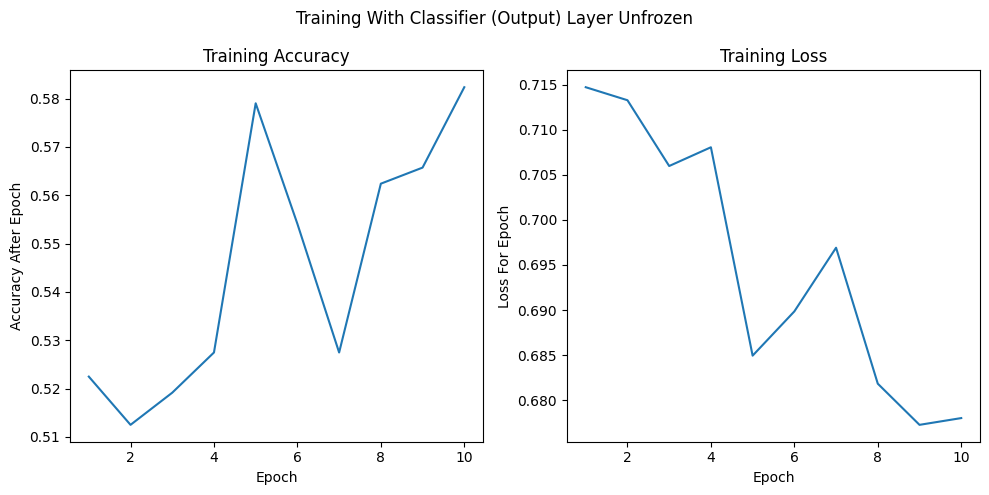

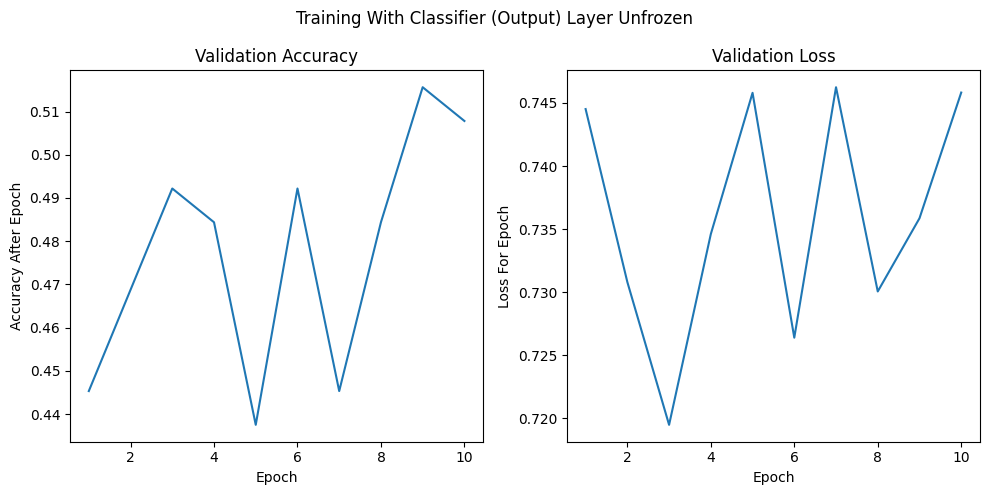

In [2]:
# This block fine-tunes the fully connected output layer of the model, beginning with the pretrained ResNet-34 model

import torch.optim as optim

model = mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Sequential(
    nn.Dropout(0.5), # implement dropout rate of 50% to discourage overfitting
    nn.Linear(model.classifier[3].in_features, num_class)
)

model.features[0][0] = nn.Conv2d(
    in_channels=1,  # Change to 1 for single-channel input
    out_channels=16,  # Keep the same as original
    kernel_size=3,
    stride=2,
    padding=1,
    bias=False
)

model = model.to(device) # move model to GPU

for param in model.parameters(): # freeze all model parameters
    param.requires_grad = False
for param in model.classifier[3].parameters(): # unfreeze fully connected layer
    param.requires_grad = True



criter = nn.CrossEntropyLoss(weight=weights) # Cross-Entropy Loss Function
optimizer = optim.Adam(model.classifier[3].parameters(), lr=1e-4) # Adam optimizer with learning rate 1e-4 to start training

num_epoch = 10 # 10 epochs

def train_model(model, dataloader, criter, optimizer, num_epoch = 5):

    train_acc = [] # list of training accuracies during this training
    train_losses = [] # list of training losses during this training
    val_acc = [] # list of validation accuracies during this training 
    val_losses = [] # list of validation losses during this training
    
    for epoch in range(num_epoch):
        print("Epoch {}/{}:\n".format(epoch+1,num_epoch)) 

        model.train() # set model to training mode
        train_loss = 0 # training loss running total starts at zero
        train_correct = 0 # correctly classified images from training set running total starts at zero
        val_loss = 0 # validation loss running total starts at zero
        val_correct = 0 # correctly classified images from validation set running total starts at zero

        for inputs, labels, labels_num in dataloader["train"]:
            inputs, labels_num = inputs.to(device), labels_num.to(device) # move inputs (images) and labels to GPU

            optimizer.zero_grad()
            outputs = model(inputs) # feed forward
            _, class_preds_train = torch.max(outputs,1) # predict classes based on model output
            loss = criter(outputs,labels_num) # generate loss values

            loss.backward() # backpropagate
            optimizer.step()

            train_loss += loss.item() * inputs.size(0) # add loss from this epoch to training loss
            train_correct += torch.sum(class_preds_train == labels_num.data) # add correctly classified images count to total correctly classified for training set

        train_loss_epoch = train_loss / len(dataloader["train"].dataset) # training loss this epoch
        train_losses.append(train_loss_epoch) # add training loss this epoch to list of training losses
        train_acc_epoch = train_correct / len(dataloader["train"].dataset) # training accuracy this epoch
        train_acc.append(train_acc_epoch) # add training accuracy this epoch to list of training accuracies

        for inputs, labels, labels_num in dataloader["val"]: # performs same loss / accuracy calculations as training set for validation set
            inputs, labels_num = inputs.to(device), labels_num.to(device) 
            
            outputs = model(inputs)
            _, class_preds_val = torch.max(outputs, 1)
            loss = criter(outputs,labels_num)

            # Do not backpropagate - no training on validation set
            
            val_loss += loss.item() * inputs.size(0)
            val_correct += torch.sum(class_preds_val == labels_num.data)

        val_loss_epoch = val_loss / len(dataloader["val"].dataset)
        val_losses.append(val_loss_epoch)
        val_acc_epoch = val_correct / len(dataloader["val"].dataset)
        val_acc.append(val_acc_epoch)

        print("Training Loss For Epoch {}: {}".format(epoch+1, train_loss_epoch))
        print("Training Accuracy After Epoch {}: {:.2f}%\n".format(epoch+1, train_acc_epoch*100))

        print("Validation Loss For Epoch {}: {}".format(epoch+1, val_loss_epoch))
        print("Validation Accuracy After Epoch {}: {:.2f}%\n".format(epoch+1, val_acc_epoch*100))
    
    return model, train_acc, train_losses, val_acc, val_losses
    
print("Training Model with Fully Connected (Output) Layer Unfrozen:\n")
dataloader = {"train": train_loader, "val": val_loader}
model, train_acc, train_losses, val_acc, val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

def plot_learning(num_epoch, accuracy, loss, layer_description, dataset='Train'):

    if dataset == 'train':
        dataset = "Training"
    if dataset == 'val':
        dataset = "Validation"
    acc_cpu = []
    loss_cpu = []

    # Move accuracy and loss tensors to CPU for numpy use
    for i in range(len(accuracy)):
        acc_cpu.append(accuracy[i].clone().detach().cpu())
        loss_cpu.append(loss[i])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) # create two subplots

    x = []
    for i in range(num_epoch):
        x.append(i+1) # Create list for X values from 0 to num_epoch for plotting

    # Plotting Accuracy vs Epoch
    ax1.plot(x, acc_cpu)
    ax1.set_title('{} Accuracy'.format(dataset))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy After Epoch')

    # Plotting Loss vs Epoch
    ax2.plot(x, loss_cpu)
    ax2.set_title('{} Loss'.format(dataset))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss For Epoch')

    plt.suptitle(layer_description)
    plt.tight_layout()

    plt.show()
    
layer_description = "Training With Classifier (Output) Layer Unfrozen"
plot_learning(num_epoch, train_acc, train_losses, layer_description, dataset="train")
plot_learning(num_epoch, val_acc, val_losses, layer_description, dataset="val")

Training Model with Classifier (Output) Layer and Next 1 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6709163566794054
Training Accuracy After Epoch 1: 58.57%

Validation Loss For Epoch 1: 0.7244807416573167
Validation Accuracy After Epoch 1: 50.00%

Epoch 2/10:

Training Loss For Epoch 2: 0.68113243897227
Training Accuracy After Epoch 2: 56.41%

Validation Loss For Epoch 2: 0.7027699975296855
Validation Accuracy After Epoch 2: 53.91%

Epoch 3/10:

Training Loss For Epoch 3: 0.6735068063767699
Training Accuracy After Epoch 3: 59.57%

Validation Loss For Epoch 3: 0.7009993083775043
Validation Accuracy After Epoch 3: 51.56%

Epoch 4/10:

Training Loss For Epoch 4: 0.6850156050156833
Training Accuracy After Epoch 4: 58.57%

Validation Loss For Epoch 4: 0.72174949105829
Validation Accuracy After Epoch 4: 60.16%

Epoch 5/10:

Training Loss For Epoch 5: 0.6681768135500827
Training Accuracy After Epoch 5: 59.57%

Validation Loss For Epoch 5: 0.7281616600230336
Validation Accura

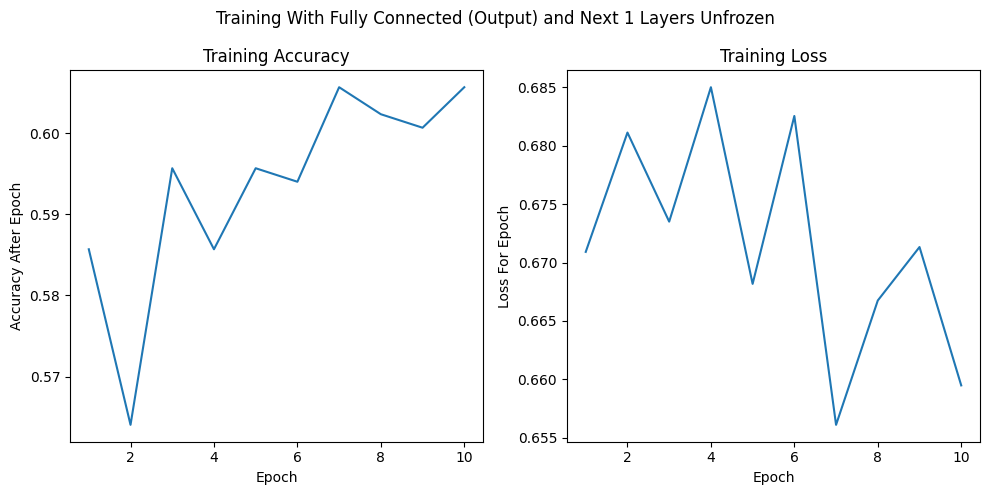

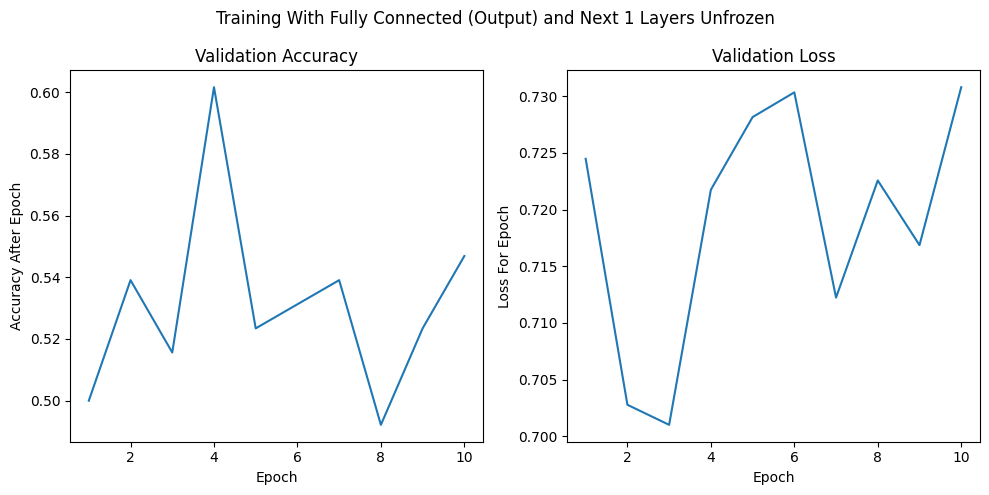

Training Model with Classifier (Output) Layer and Next 2 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6733856377704767
Training Accuracy After Epoch 1: 59.90%

Validation Loss For Epoch 1: 0.7374765546992421
Validation Accuracy After Epoch 1: 51.56%

Epoch 2/10:

Training Loss For Epoch 2: 0.6805404721202946
Training Accuracy After Epoch 2: 59.57%

Validation Loss For Epoch 2: 0.7156616831198335
Validation Accuracy After Epoch 2: 50.00%

Epoch 3/10:

Training Loss For Epoch 3: 0.6552089347617202
Training Accuracy After Epoch 3: 59.73%

Validation Loss For Epoch 3: 0.7332751201465726
Validation Accuracy After Epoch 3: 46.09%

Epoch 4/10:

Training Loss For Epoch 4: 0.6615986523533026
Training Accuracy After Epoch 4: 60.90%

Validation Loss For Epoch 4: 0.7333575719967484
Validation Accuracy After Epoch 4: 53.12%

Epoch 5/10:

Training Loss For Epoch 5: 0.6539927234070472
Training Accuracy After Epoch 5: 61.90%

Validation Loss For Epoch 5: 0.713408324867487
Validation Acc

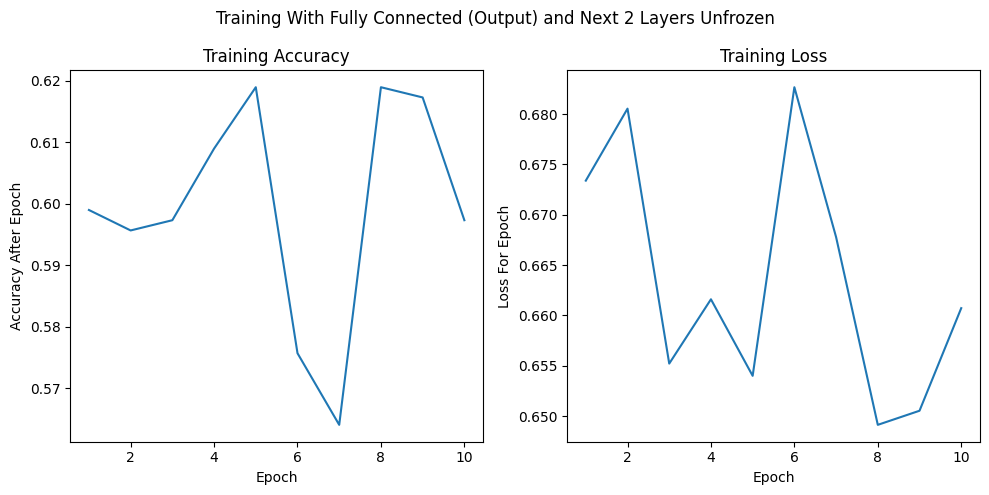

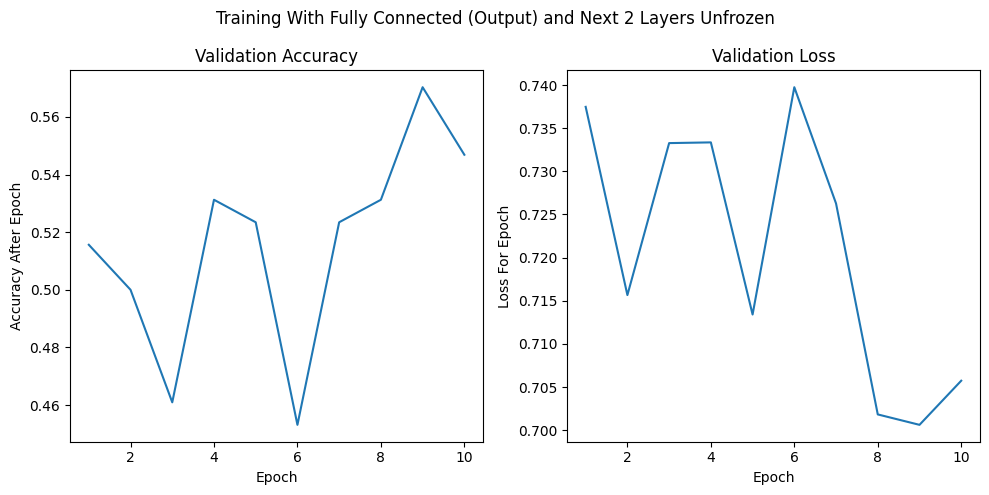

Training Model with Classifier (Output) Layer and Next 3 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6599178004780546
Training Accuracy After Epoch 1: 60.73%

Validation Loss For Epoch 1: 0.7237676400691271
Validation Accuracy After Epoch 1: 50.00%

Epoch 2/10:

Training Loss For Epoch 2: 0.6734560421619955
Training Accuracy After Epoch 2: 57.24%

Validation Loss For Epoch 2: 0.7162477010861039
Validation Accuracy After Epoch 2: 60.16%

Epoch 3/10:

Training Loss For Epoch 3: 0.6624765784887228
Training Accuracy After Epoch 3: 60.90%

Validation Loss For Epoch 3: 0.7502146726474166
Validation Accuracy After Epoch 3: 46.09%

Epoch 4/10:

Training Loss For Epoch 4: 0.6650499477362672
Training Accuracy After Epoch 4: 59.23%

Validation Loss For Epoch 4: 0.7267208024859428
Validation Accuracy After Epoch 4: 47.66%

Epoch 5/10:

Training Loss For Epoch 5: 0.6805095739055196
Training Accuracy After Epoch 5: 56.24%

Validation Loss For Epoch 5: 0.6869370974600315
Validation Ac

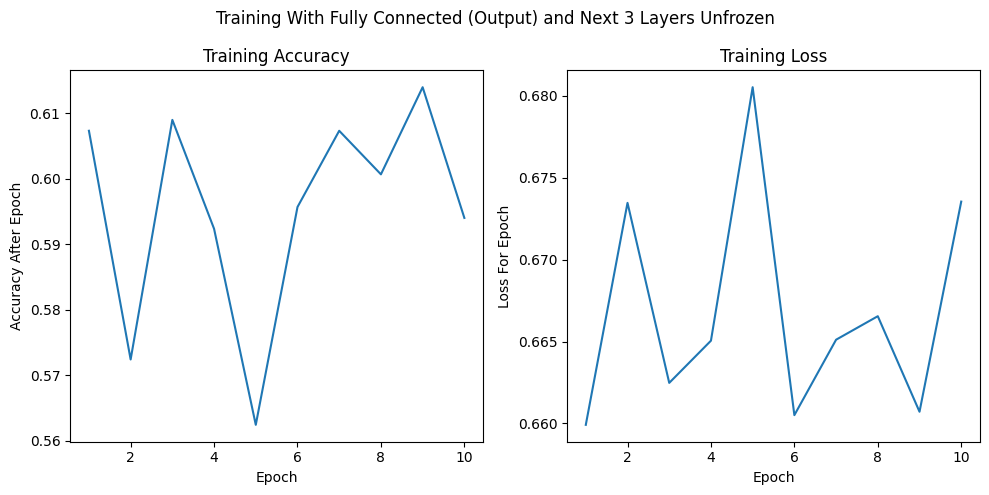

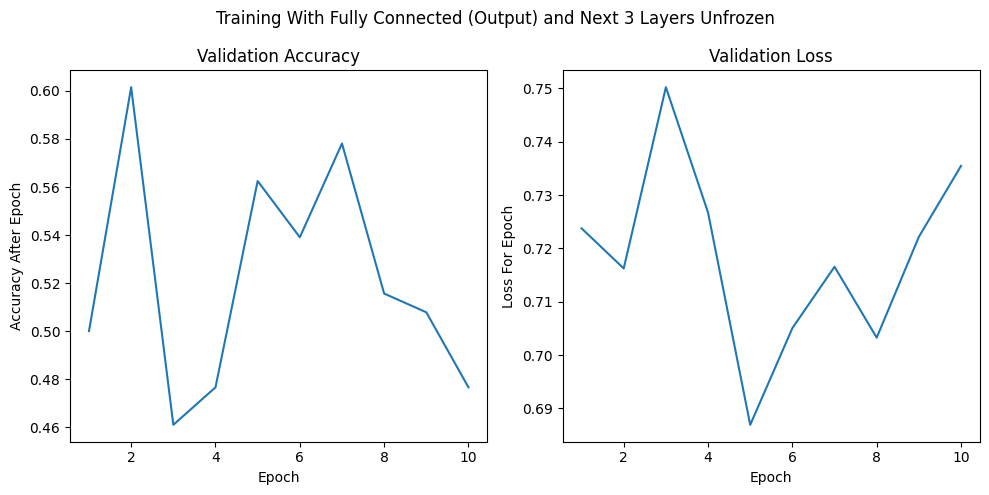

Training Model with Classifier (Output) Layer and Next 4 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6686651552973095
Training Accuracy After Epoch 1: 60.40%

Validation Loss For Epoch 1: 0.736272738315165
Validation Accuracy After Epoch 1: 52.34%

Epoch 2/10:

Training Loss For Epoch 2: 0.6546705161870617
Training Accuracy After Epoch 2: 62.40%

Validation Loss For Epoch 2: 0.7196867130696774
Validation Accuracy After Epoch 2: 54.69%

Epoch 3/10:

Training Loss For Epoch 3: 0.6679671840144077
Training Accuracy After Epoch 3: 59.57%

Validation Loss For Epoch 3: 0.7182792155072093
Validation Accuracy After Epoch 3: 53.91%

Epoch 4/10:

Training Loss For Epoch 4: 0.6665381151507183
Training Accuracy After Epoch 4: 58.24%

Validation Loss For Epoch 4: 0.7299393573775887
Validation Accuracy After Epoch 4: 51.56%

Epoch 5/10:

Training Loss For Epoch 5: 0.6630794720324422
Training Accuracy After Epoch 5: 59.57%

Validation Loss For Epoch 5: 0.7210716148838401
Validation Acc

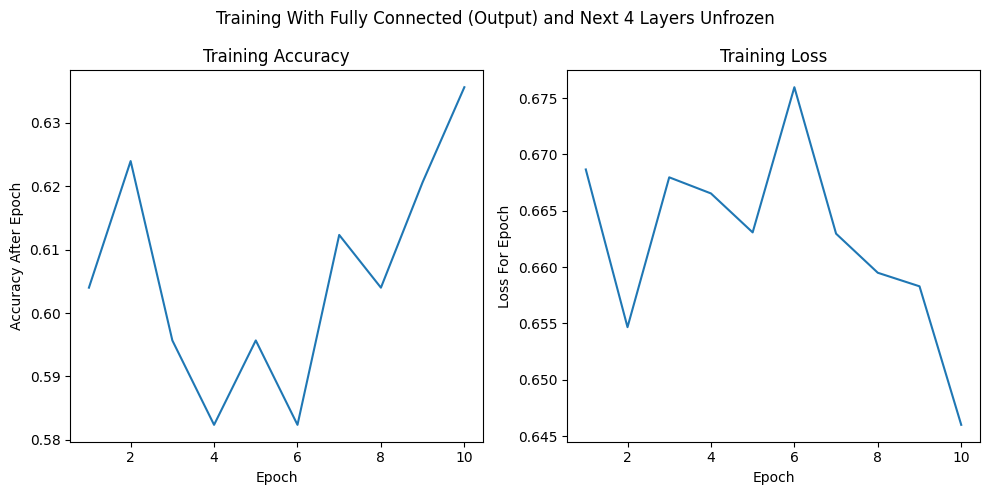

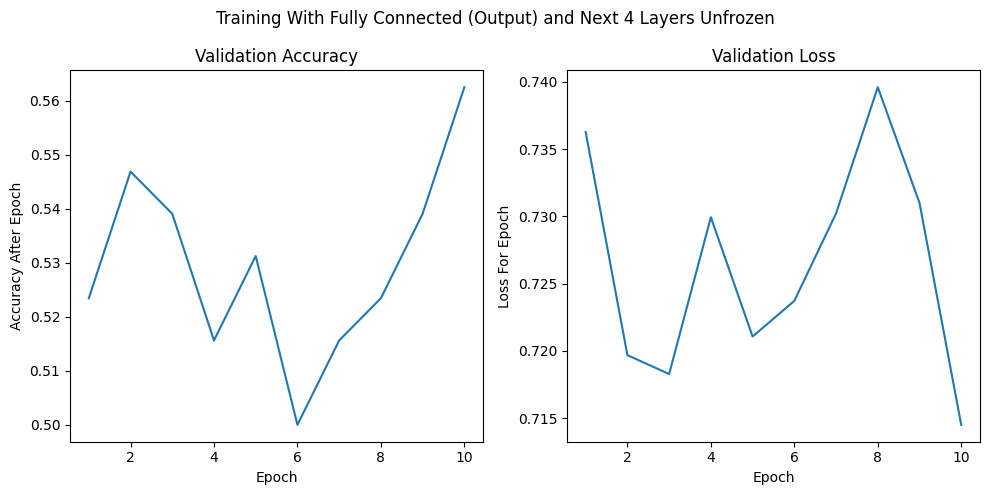

Training Model with Classifier (Output) Layer and Next 5 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6549867211086381
Training Accuracy After Epoch 1: 62.90%

Validation Loss For Epoch 1: 0.7134183840826154
Validation Accuracy After Epoch 1: 53.91%

Epoch 2/10:

Training Loss For Epoch 2: 0.648149277029339
Training Accuracy After Epoch 2: 64.23%

Validation Loss For Epoch 2: 0.7364669013768435
Validation Accuracy After Epoch 2: 48.44%

Epoch 3/10:

Training Loss For Epoch 3: 0.6423536733462291
Training Accuracy After Epoch 3: 64.73%

Validation Loss For Epoch 3: 0.7268508803099394
Validation Accuracy After Epoch 3: 52.34%

Epoch 4/10:

Training Loss For Epoch 4: 0.6702631838904839
Training Accuracy After Epoch 4: 59.23%

Validation Loss For Epoch 4: 0.702529669739306
Validation Accuracy After Epoch 4: 57.03%

Epoch 5/10:

Training Loss For Epoch 5: 0.6402823742534872
Training Accuracy After Epoch 5: 63.89%

Validation Loss For Epoch 5: 0.7061768546700478
Validation Accu

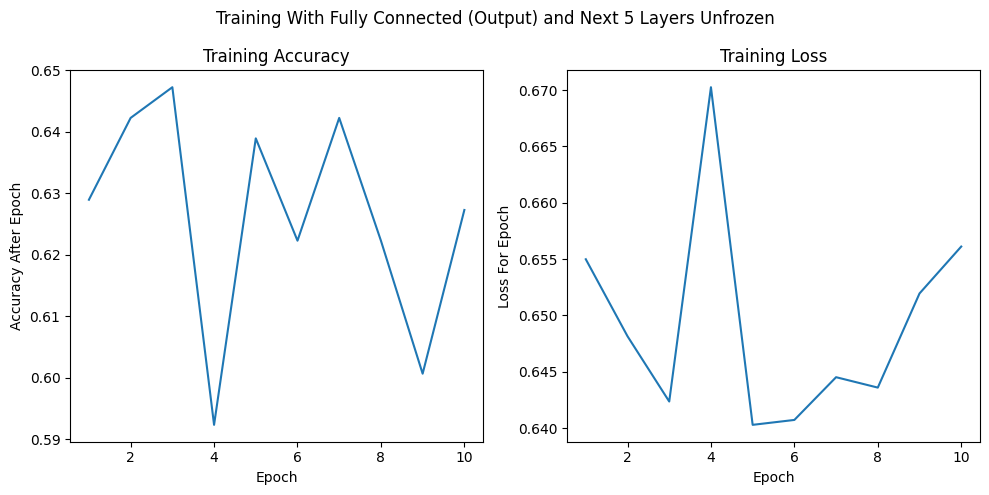

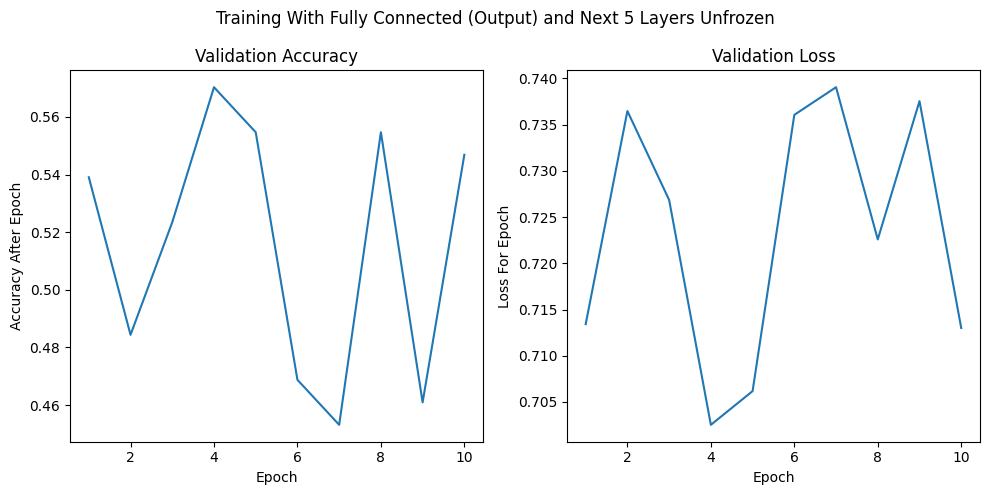

Training Model with Classifier (Output) Layer and Next 6 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6597706118161587
Training Accuracy After Epoch 1: 59.73%

Validation Loss For Epoch 1: 0.7230285443365574
Validation Accuracy After Epoch 1: 57.03%

Epoch 2/10:

Training Loss For Epoch 2: 0.6619069603040889
Training Accuracy After Epoch 2: 58.57%

Validation Loss For Epoch 2: 0.7364815324544907
Validation Accuracy After Epoch 2: 46.88%

Epoch 3/10:

Training Loss For Epoch 3: 0.6388674948655825
Training Accuracy After Epoch 3: 62.23%

Validation Loss For Epoch 3: 0.699589416384697
Validation Accuracy After Epoch 3: 57.81%

Epoch 4/10:

Training Loss For Epoch 4: 0.650685855632217
Training Accuracy After Epoch 4: 63.23%

Validation Loss For Epoch 4: 0.7339742509648204
Validation Accuracy After Epoch 4: 52.34%

Epoch 5/10:

Training Loss For Epoch 5: 0.6626119057271326
Training Accuracy After Epoch 5: 60.23%

Validation Loss For Epoch 5: 0.7146876556798816
Validation Accu

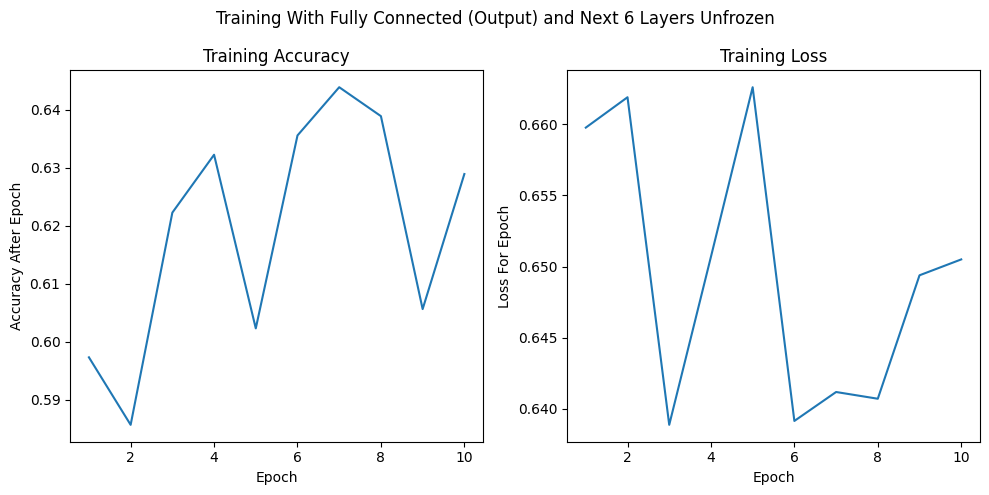

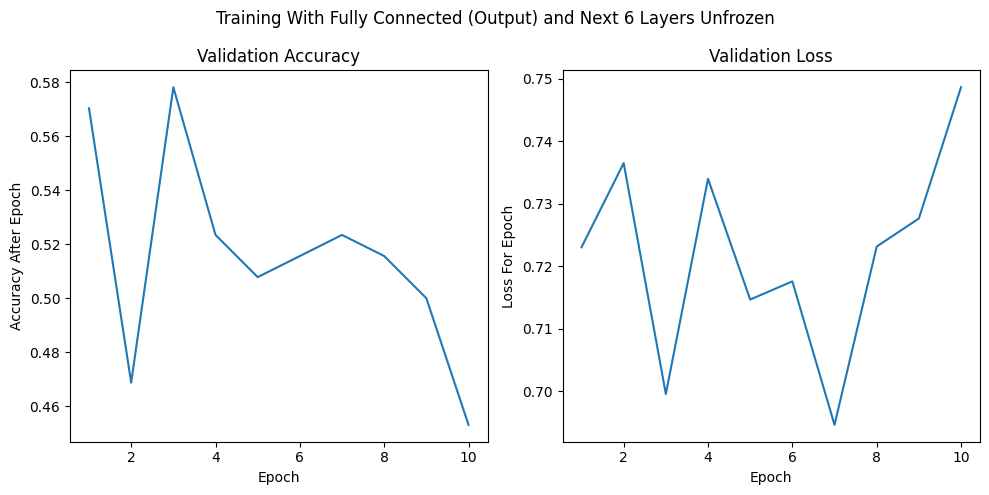

Training Model with Classifier (Output) Layer and Next 7 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6632493952546461
Training Accuracy After Epoch 1: 58.90%

Validation Loss For Epoch 1: 0.729415325447917
Validation Accuracy After Epoch 1: 49.22%

Epoch 2/10:

Training Loss For Epoch 2: 0.6454178588759284
Training Accuracy After Epoch 2: 63.39%

Validation Loss For Epoch 2: 0.6941470000892878
Validation Accuracy After Epoch 2: 56.25%

Epoch 3/10:

Training Loss For Epoch 3: 0.6274029781140028
Training Accuracy After Epoch 3: 65.06%

Validation Loss For Epoch 3: 0.7119354084134102
Validation Accuracy After Epoch 3: 52.34%

Epoch 4/10:

Training Loss For Epoch 4: 0.638775260991939
Training Accuracy After Epoch 4: 63.23%

Validation Loss For Epoch 4: 0.6907043717801571
Validation Accuracy After Epoch 4: 59.38%

Epoch 5/10:

Training Loss For Epoch 5: 0.6374910006705615
Training Accuracy After Epoch 5: 64.23%

Validation Loss For Epoch 5: 0.7036759313195944
Validation Accu

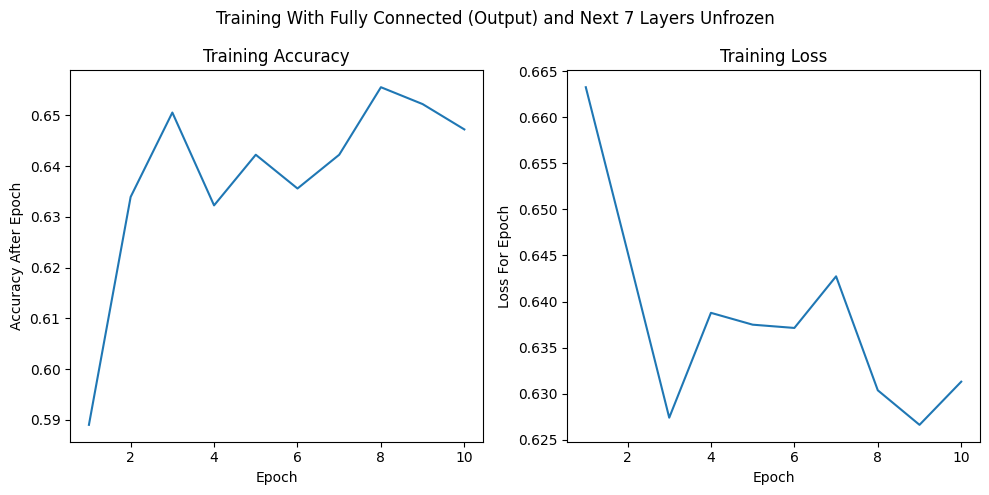

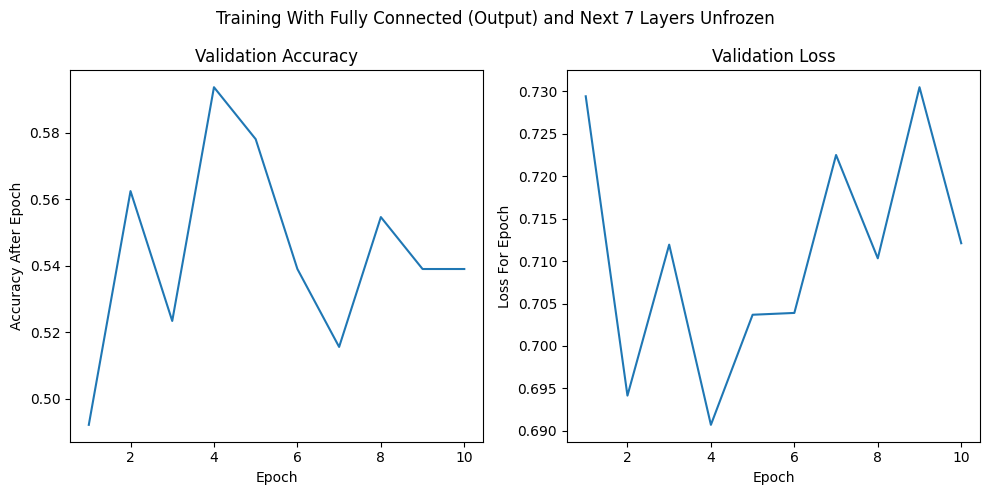

Training Model with Classifier (Output) Layer and Next 8 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6452447572682741
Training Accuracy After Epoch 1: 62.40%

Validation Loss For Epoch 1: 0.7310334257781506
Validation Accuracy After Epoch 1: 49.22%

Epoch 2/10:

Training Loss For Epoch 2: 0.6205526329514984
Training Accuracy After Epoch 2: 67.39%

Validation Loss For Epoch 2: 0.7164379889145494
Validation Accuracy After Epoch 2: 53.12%

Epoch 3/10:

Training Loss For Epoch 3: 0.641175785794631
Training Accuracy After Epoch 3: 63.39%

Validation Loss For Epoch 3: 0.7312605287879705
Validation Accuracy After Epoch 3: 53.91%

Epoch 4/10:

Training Loss For Epoch 4: 0.6227720658513353
Training Accuracy After Epoch 4: 66.56%

Validation Loss For Epoch 4: 0.6935716941952705
Validation Accuracy After Epoch 4: 57.03%

Epoch 5/10:

Training Loss For Epoch 5: 0.6079262420659057
Training Accuracy After Epoch 5: 66.72%

Validation Loss For Epoch 5: 0.7329860059544444
Validation Acc

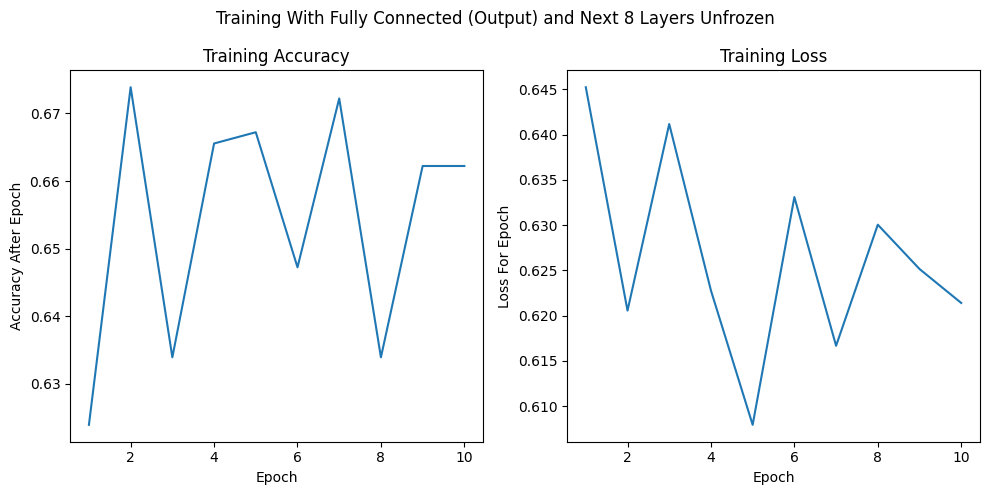

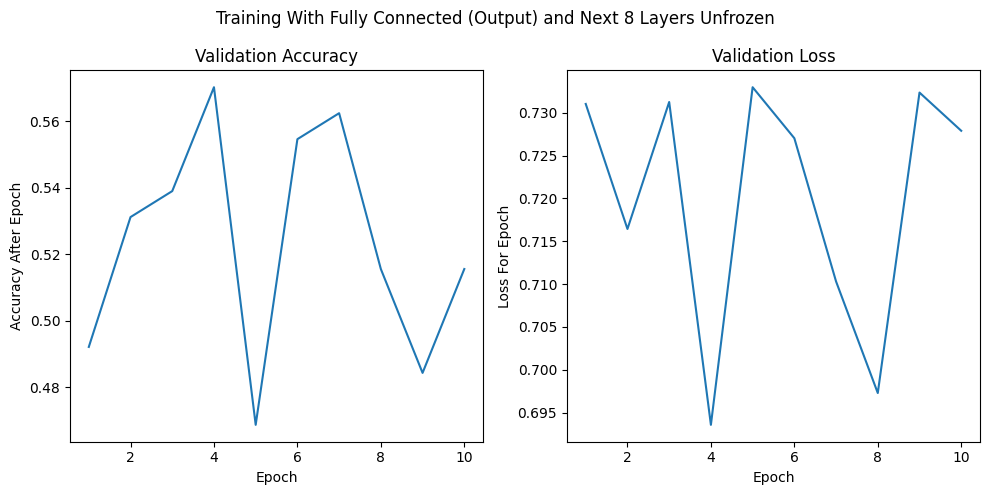

Training Model with Classifier (Output) Layer and Next 9 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.6299543062383045
Training Accuracy After Epoch 1: 64.73%

Validation Loss For Epoch 1: 0.7200850611552596
Validation Accuracy After Epoch 1: 57.03%

Epoch 2/10:

Training Loss For Epoch 2: 0.6186280076991698
Training Accuracy After Epoch 2: 69.22%

Validation Loss For Epoch 2: 0.7176840780302882
Validation Accuracy After Epoch 2: 51.56%

Epoch 3/10:

Training Loss For Epoch 3: 0.6099477896277797
Training Accuracy After Epoch 3: 68.72%

Validation Loss For Epoch 3: 0.7003660863265395
Validation Accuracy After Epoch 3: 52.34%

Epoch 4/10:

Training Loss For Epoch 4: 0.6217904531221818
Training Accuracy After Epoch 4: 66.89%

Validation Loss For Epoch 4: 0.7041877554729581
Validation Accuracy After Epoch 4: 57.03%

Epoch 5/10:

Training Loss For Epoch 5: 0.616139967211471
Training Accuracy After Epoch 5: 66.72%

Validation Loss For Epoch 5: 0.6950971568003297
Validation Acc

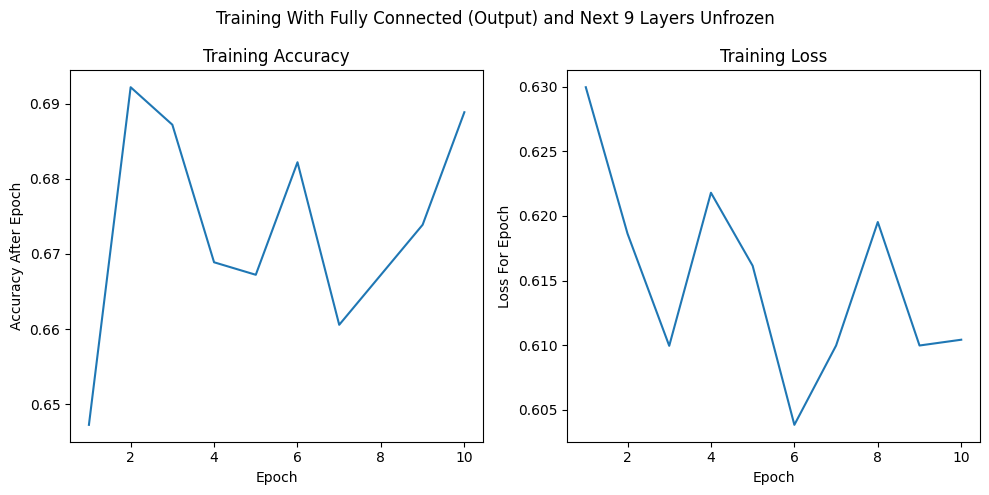

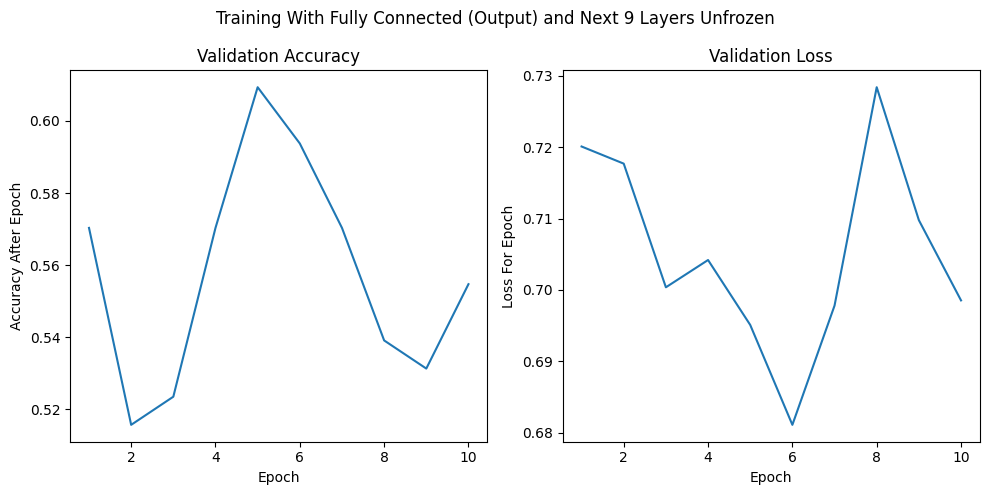

Training Model with Classifier (Output) Layer and Next 10 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.5951430521868232
Training Accuracy After Epoch 1: 68.72%

Validation Loss For Epoch 1: 0.6893514432013035
Validation Accuracy After Epoch 1: 56.25%

Epoch 2/10:

Training Loss For Epoch 2: 0.5972852344421697
Training Accuracy After Epoch 2: 69.38%

Validation Loss For Epoch 2: 0.6940029198303819
Validation Accuracy After Epoch 2: 57.81%

Epoch 3/10:

Training Loss For Epoch 3: 0.6103782285866444
Training Accuracy After Epoch 3: 66.72%

Validation Loss For Epoch 3: 0.728133681230247
Validation Accuracy After Epoch 3: 49.22%

Epoch 4/10:

Training Loss For Epoch 4: 0.596515543845648
Training Accuracy After Epoch 4: 69.72%

Validation Loss For Epoch 4: 0.704022316262126
Validation Accuracy After Epoch 4: 55.47%

Epoch 5/10:

Training Loss For Epoch 5: 0.5926505851864616
Training Accuracy After Epoch 5: 69.72%

Validation Loss For Epoch 5: 0.7445429880172014
Validation Accu

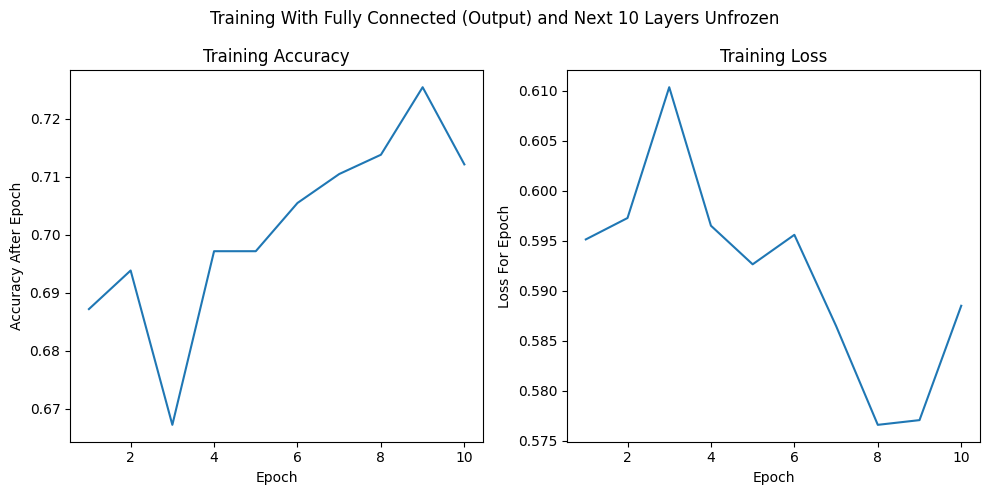

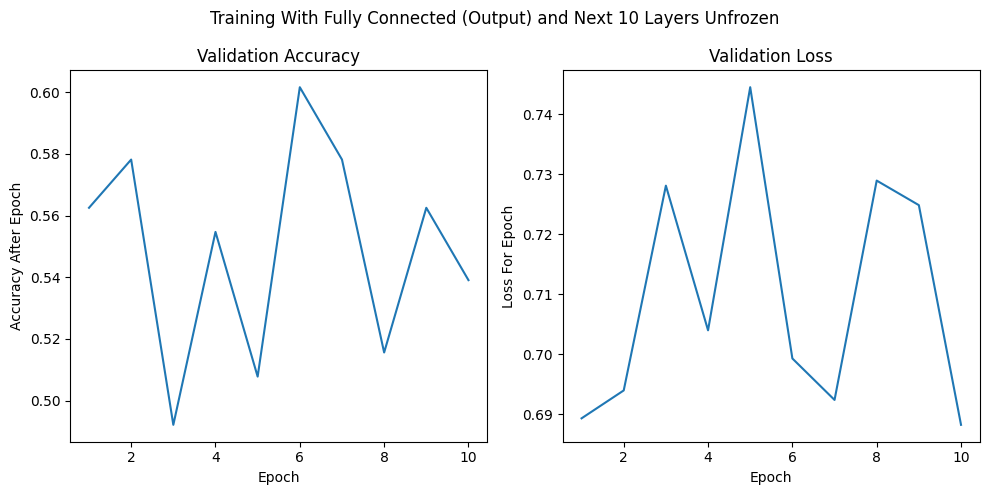

Training Model with Classifier (Output) Layer and Next 11 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.5790284564114252
Training Accuracy After Epoch 1: 71.88%

Validation Loss For Epoch 1: 0.7113151084631681
Validation Accuracy After Epoch 1: 57.03%

Epoch 2/10:

Training Loss For Epoch 2: 0.587281951789253
Training Accuracy After Epoch 2: 71.55%

Validation Loss For Epoch 2: 0.7042084606364369
Validation Accuracy After Epoch 2: 58.59%

Epoch 3/10:

Training Loss For Epoch 3: 0.5691051430591133
Training Accuracy After Epoch 3: 74.21%

Validation Loss For Epoch 3: 0.7070104982703924
Validation Accuracy After Epoch 3: 56.25%

Epoch 4/10:

Training Loss For Epoch 4: 0.5767947110082464
Training Accuracy After Epoch 4: 73.71%

Validation Loss For Epoch 4: 0.717352818697691
Validation Accuracy After Epoch 4: 58.59%

Epoch 5/10:

Training Loss For Epoch 5: 0.5840990817090636
Training Accuracy After Epoch 5: 72.55%

Validation Loss For Epoch 5: 0.7014785660430789
Validation Acc

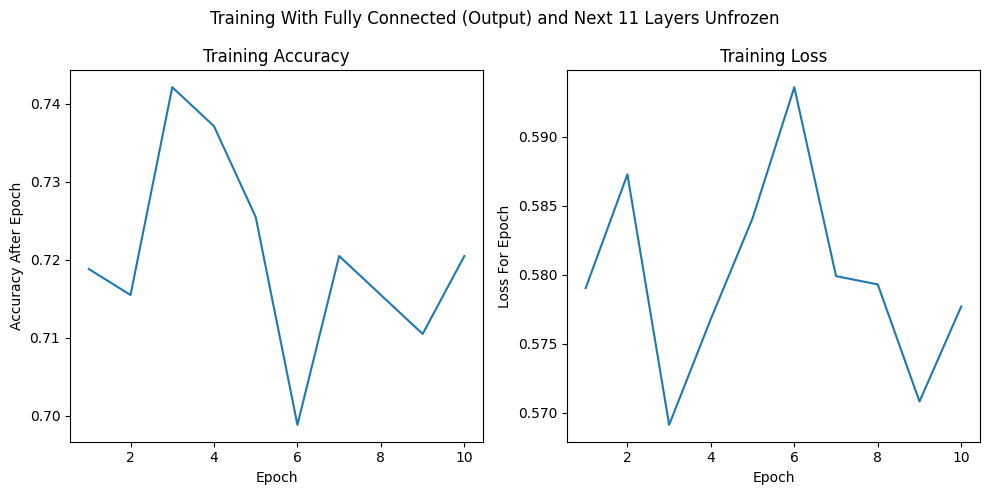

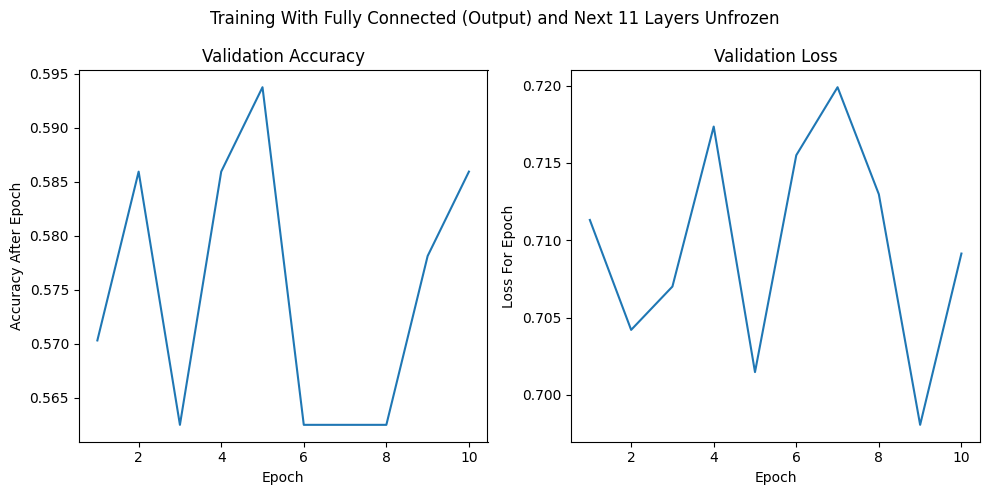

Training Model with Classifier (Output) Layer and Next 12 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.574711804183668
Training Accuracy After Epoch 1: 72.21%

Validation Loss For Epoch 1: 0.7225490584969521
Validation Accuracy After Epoch 1: 56.25%

Epoch 2/10:

Training Loss For Epoch 2: 0.5680682737498037
Training Accuracy After Epoch 2: 74.21%

Validation Loss For Epoch 2: 0.704691675491631
Validation Accuracy After Epoch 2: 56.25%

Epoch 3/10:

Training Loss For Epoch 3: 0.5653561035329212
Training Accuracy After Epoch 3: 73.71%

Validation Loss For Epoch 3: 0.6971410671249032
Validation Accuracy After Epoch 3: 63.28%

Epoch 4/10:

Training Loss For Epoch 4: 0.5613453036140087
Training Accuracy After Epoch 4: 73.04%

Validation Loss For Epoch 4: 0.7282283920794725
Validation Accuracy After Epoch 4: 53.91%

Epoch 5/10:

Training Loss For Epoch 5: 0.5560576936072003
Training Accuracy After Epoch 5: 74.88%

Validation Loss For Epoch 5: 0.7157938200980425
Validation Acc

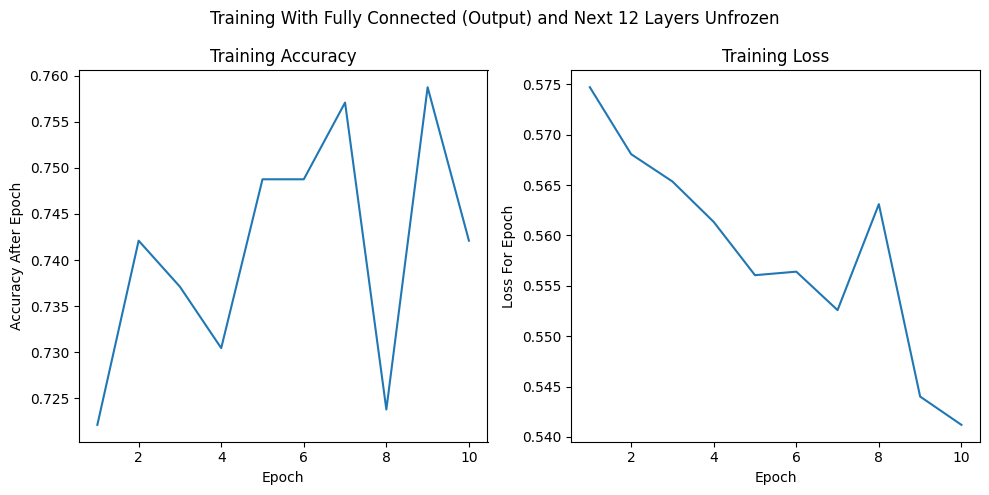

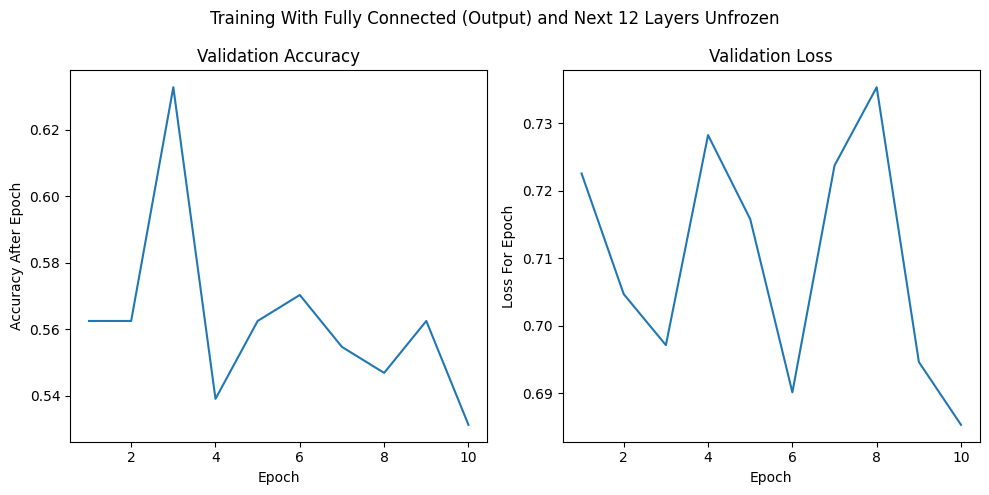

Training Model with Classifier (Output) Layer and Next 13 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.5420718817861624
Training Accuracy After Epoch 1: 76.21%

Validation Loss For Epoch 1: 0.7010900564491749
Validation Accuracy After Epoch 1: 54.69%

Epoch 2/10:

Training Loss For Epoch 2: 0.5080938554444845
Training Accuracy After Epoch 2: 80.03%

Validation Loss For Epoch 2: 0.7028672015294433
Validation Accuracy After Epoch 2: 61.72%

Epoch 3/10:

Training Loss For Epoch 3: 0.5333100601956372
Training Accuracy After Epoch 3: 76.37%

Validation Loss For Epoch 3: 0.7027849666774273
Validation Accuracy After Epoch 3: 56.25%

Epoch 4/10:

Training Loss For Epoch 4: 0.5295197026503463
Training Accuracy After Epoch 4: 78.54%

Validation Loss For Epoch 4: 0.7275582356378436
Validation Accuracy After Epoch 4: 52.34%

Epoch 5/10:

Training Loss For Epoch 5: 0.5242184415434838
Training Accuracy After Epoch 5: 76.54%

Validation Loss For Epoch 5: 0.7232888136059046
Validation A

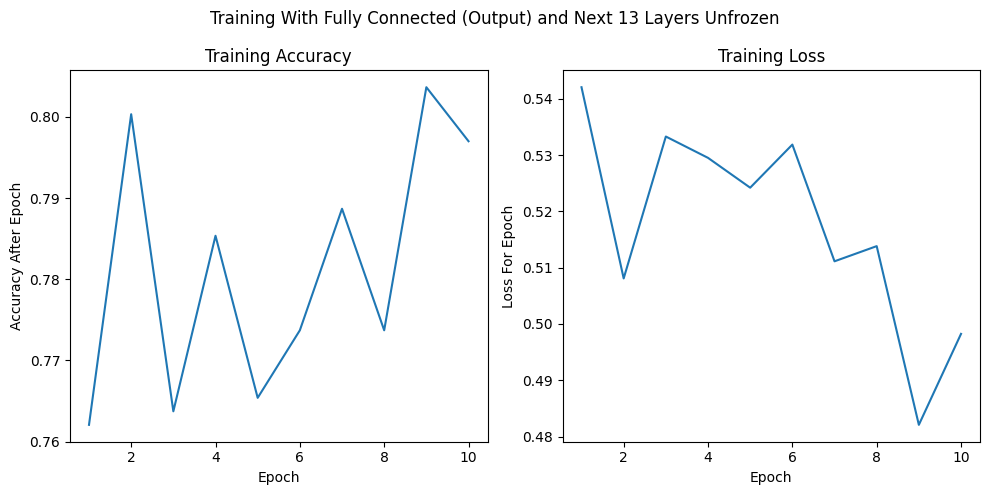

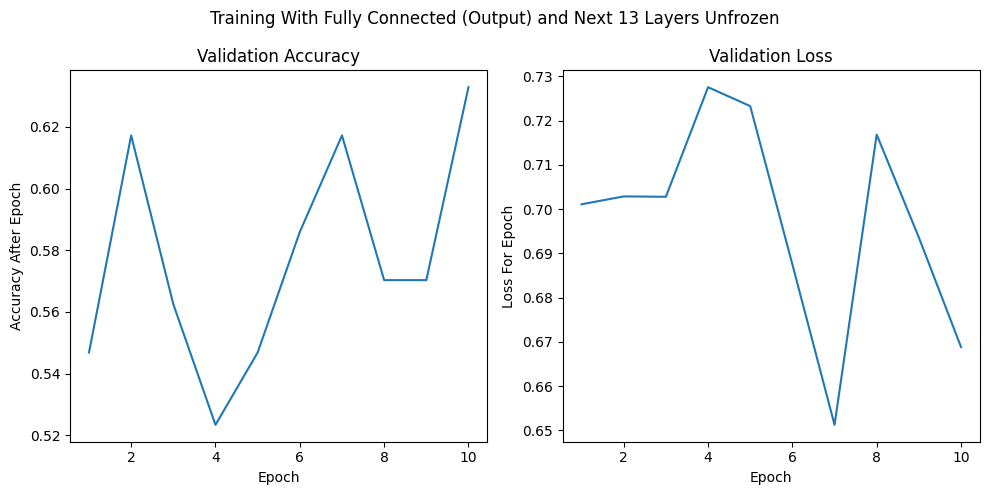

Training Model with Classifier (Output) Layer and Next 14 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.47921721153767055
Training Accuracy After Epoch 1: 81.86%

Validation Loss For Epoch 1: 0.7048869710415602
Validation Accuracy After Epoch 1: 57.81%

Epoch 2/10:

Training Loss For Epoch 2: 0.4690975005337085
Training Accuracy After Epoch 2: 82.03%

Validation Loss For Epoch 2: 0.701948375441134
Validation Accuracy After Epoch 2: 57.03%

Epoch 3/10:

Training Loss For Epoch 3: 0.4835762431141541
Training Accuracy After Epoch 3: 80.70%

Validation Loss For Epoch 3: 0.6751762013882399
Validation Accuracy After Epoch 3: 64.06%

Epoch 4/10:

Training Loss For Epoch 4: 0.4568842745660347
Training Accuracy After Epoch 4: 84.69%

Validation Loss For Epoch 4: 0.7251318339258432
Validation Accuracy After Epoch 4: 53.91%

Epoch 5/10:

Training Loss For Epoch 5: 0.46089004438847747
Training Accuracy After Epoch 5: 84.53%

Validation Loss For Epoch 5: 0.7059809025377035
Validation 

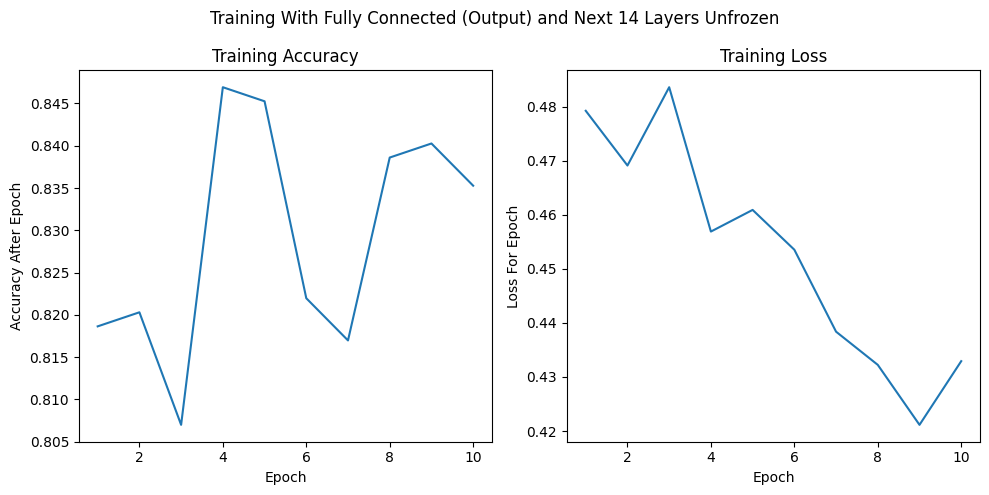

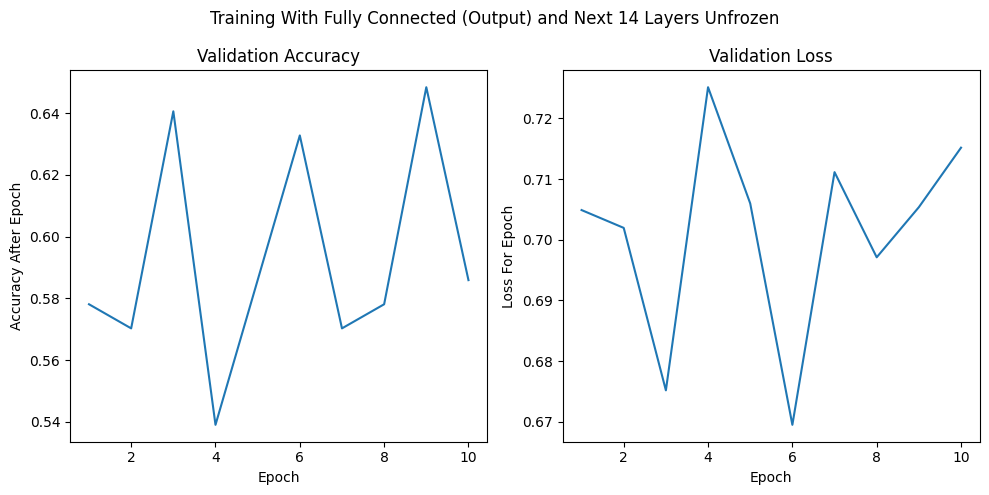

Training Model with Classifier (Output) Layer and Next 15 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.4141989604704789
Training Accuracy After Epoch 1: 85.19%

Validation Loss For Epoch 1: 0.6850098129361868
Validation Accuracy After Epoch 1: 62.50%

Epoch 2/10:

Training Loss For Epoch 2: 0.38776848667274894
Training Accuracy After Epoch 2: 87.69%

Validation Loss For Epoch 2: 0.7149170059710741
Validation Accuracy After Epoch 2: 58.59%

Epoch 3/10:

Training Loss For Epoch 3: 0.4082333933493857
Training Accuracy After Epoch 3: 84.03%

Validation Loss For Epoch 3: 0.7023350219242275
Validation Accuracy After Epoch 3: 64.06%

Epoch 4/10:

Training Loss For Epoch 4: 0.37585548339984975
Training Accuracy After Epoch 4: 87.52%

Validation Loss For Epoch 4: 0.6988437990657985
Validation Accuracy After Epoch 4: 58.59%

Epoch 5/10:

Training Loss For Epoch 5: 0.3596697474973967
Training Accuracy After Epoch 5: 88.35%

Validation Loss For Epoch 5: 0.711575819645077
Validation 

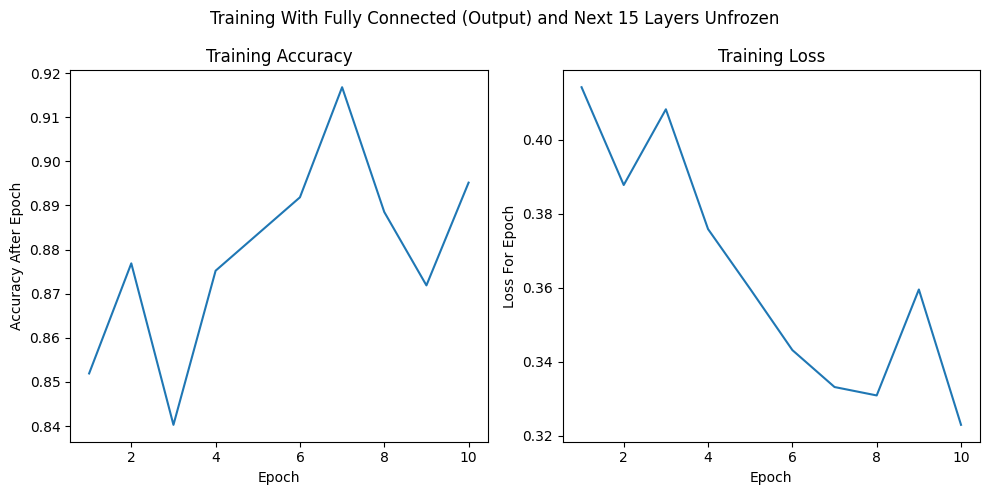

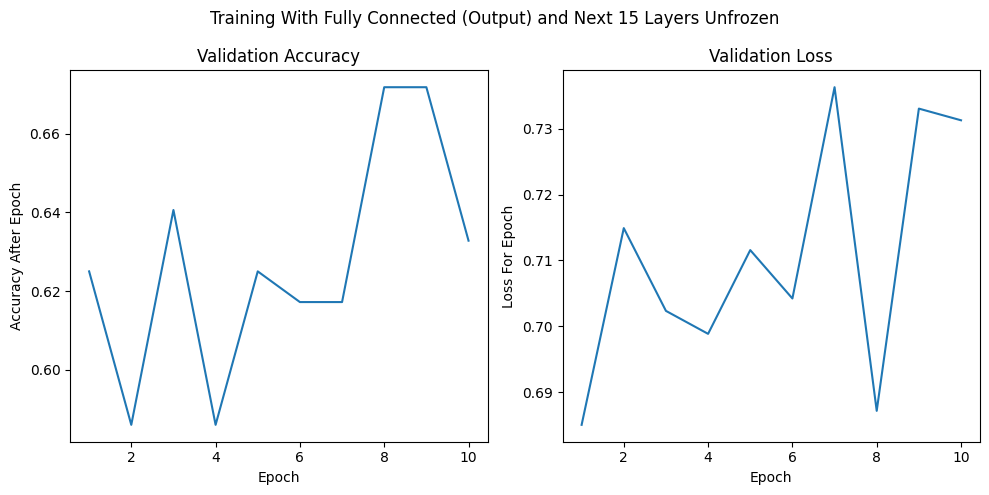

Training Model with Classifier (Output) Layer and Next 16 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.32356266040175213
Training Accuracy After Epoch 1: 88.85%

Validation Loss For Epoch 1: 0.7353854919783771
Validation Accuracy After Epoch 1: 60.94%

Epoch 2/10:

Training Loss For Epoch 2: 0.2870417783244477
Training Accuracy After Epoch 2: 92.18%

Validation Loss For Epoch 2: 0.7135182349011302
Validation Accuracy After Epoch 2: 64.06%

Epoch 3/10:

Training Loss For Epoch 3: 0.30579284542610563
Training Accuracy After Epoch 3: 89.18%

Validation Loss For Epoch 3: 0.7034052670933306
Validation Accuracy After Epoch 3: 64.84%

Epoch 4/10:

Training Loss For Epoch 4: 0.30002908453270916
Training Accuracy After Epoch 4: 89.85%

Validation Loss For Epoch 4: 0.7310950092505664
Validation Accuracy After Epoch 4: 62.50%

Epoch 5/10:

Training Loss For Epoch 5: 0.27095632493099236
Training Accuracy After Epoch 5: 90.35%

Validation Loss For Epoch 5: 0.7702237670309842
Validati

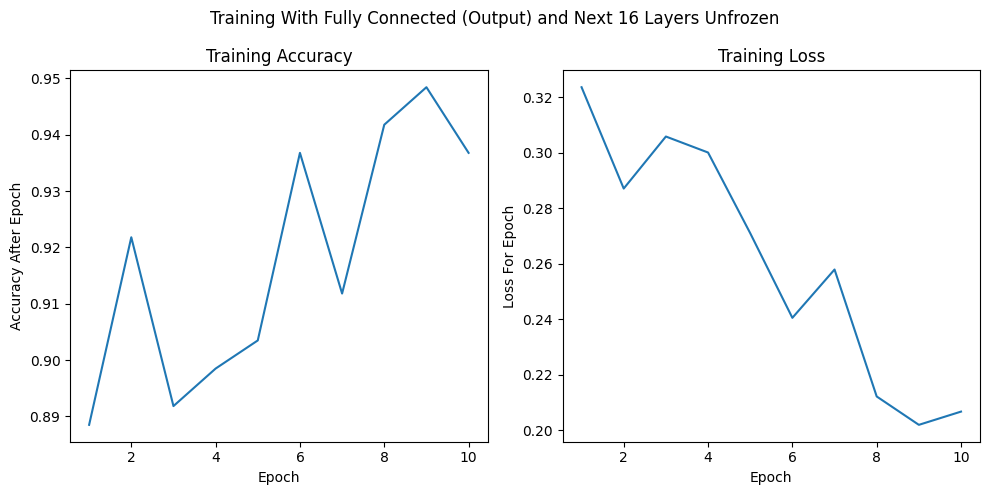

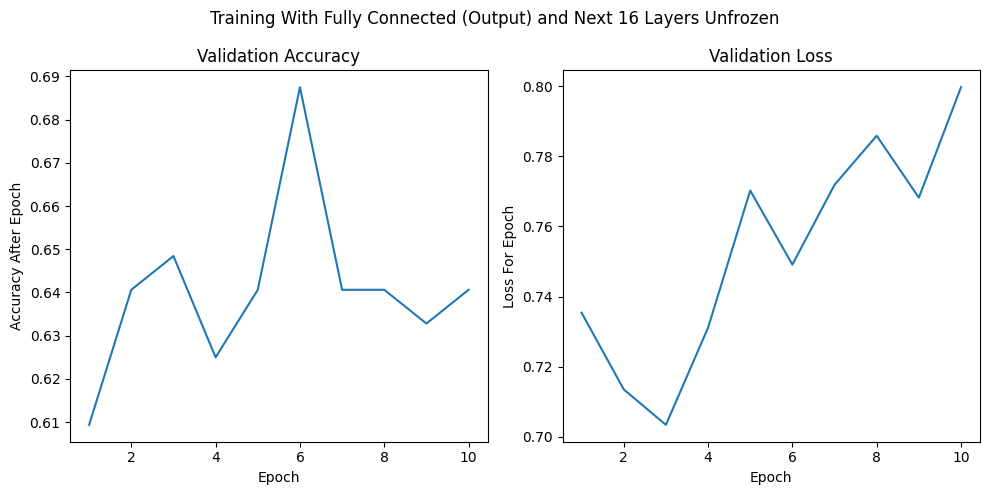

Training Model with Classifier (Output) Layer and Next 17 Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.19149987440488103
Training Accuracy After Epoch 1: 94.51%

Validation Loss For Epoch 1: 0.7951372228562832
Validation Accuracy After Epoch 1: 64.06%

Epoch 2/10:

Training Loss For Epoch 2: 0.1840102410628871
Training Accuracy After Epoch 2: 95.17%

Validation Loss For Epoch 2: 0.7994373138062656
Validation Accuracy After Epoch 2: 64.06%

Epoch 3/10:

Training Loss For Epoch 3: 0.18911584108423274
Training Accuracy After Epoch 3: 93.84%

Validation Loss For Epoch 3: 0.851500101853162
Validation Accuracy After Epoch 3: 63.28%

Epoch 4/10:

Training Loss For Epoch 4: 0.20225108009507375
Training Accuracy After Epoch 4: 93.51%

Validation Loss For Epoch 4: 0.8026009383611381
Validation Accuracy After Epoch 4: 67.19%

Epoch 5/10:

Training Loss For Epoch 5: 0.1682856514702819
Training Accuracy After Epoch 5: 95.34%

Validation Loss For Epoch 5: 0.8125268528237939
Validation

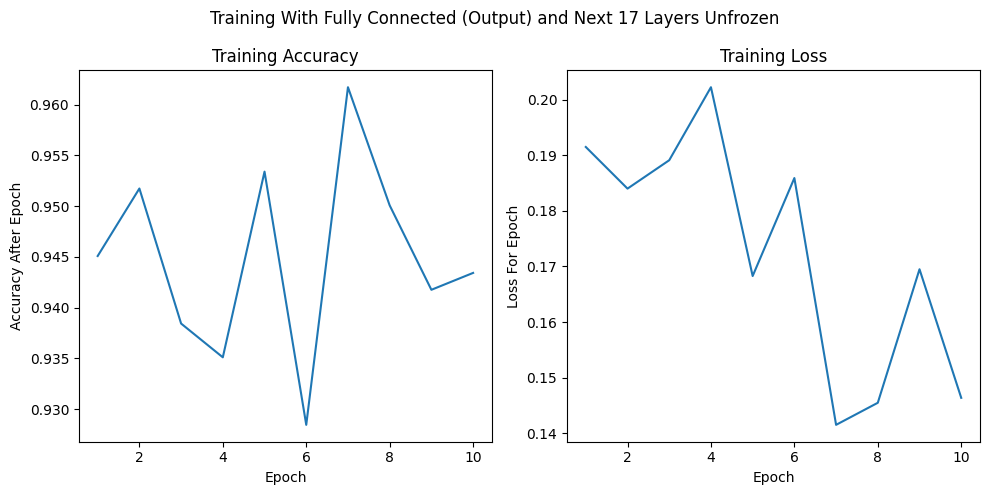

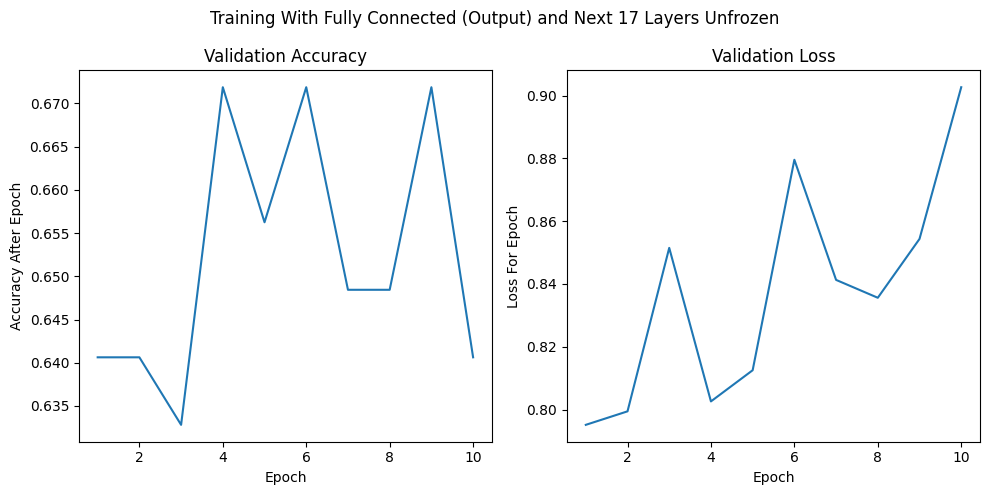

In [3]:
# This block sequentially fine-tunes remaining layers of model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # implements lower learning rate for remaining layers
for i, layer in enumerate(model.features):
    for param in layer.parameters():
        param.requires_grad = True

    print("Training Model with Classifier (Output) Layer and Next {} Layers Unfrozen:\n".format(i+1))
    model, layer_train_acc, layer_train_losses, layer_val_acc, layer_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

    layer_description = "Training With Fully Connected (Output) and Next {} Layers Unfrozen".format(i+1)
    plot_learning(num_epoch, layer_train_acc, layer_train_losses, layer_description, dataset="train")
    plot_learning(num_epoch, layer_val_acc, layer_val_losses, layer_description, dataset="val")

Training Model With All Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.13780083408123642
Training Accuracy After Epoch 1: 95.51%

Validation Loss For Epoch 1: 0.891376375220716
Validation Accuracy After Epoch 1: 67.19%

Epoch 2/10:

Training Loss For Epoch 2: 0.11481478413607236
Training Accuracy After Epoch 2: 96.84%

Validation Loss For Epoch 2: 0.9200205763336271
Validation Accuracy After Epoch 2: 69.53%

Epoch 3/10:

Training Loss For Epoch 3: 0.11867396273772648
Training Accuracy After Epoch 3: 96.01%

Validation Loss For Epoch 3: 0.8865698645822704
Validation Accuracy After Epoch 3: 71.09%

Epoch 4/10:

Training Loss For Epoch 4: 0.08830514409503405
Training Accuracy After Epoch 4: 98.17%

Validation Loss For Epoch 4: 0.9062584977364168
Validation Accuracy After Epoch 4: 69.53%

Epoch 5/10:

Training Loss For Epoch 5: 0.13102604657994232
Training Accuracy After Epoch 5: 95.01%

Validation Loss For Epoch 5: 0.9334539761766791
Validation Accuracy After Epoch 5: 69.53%


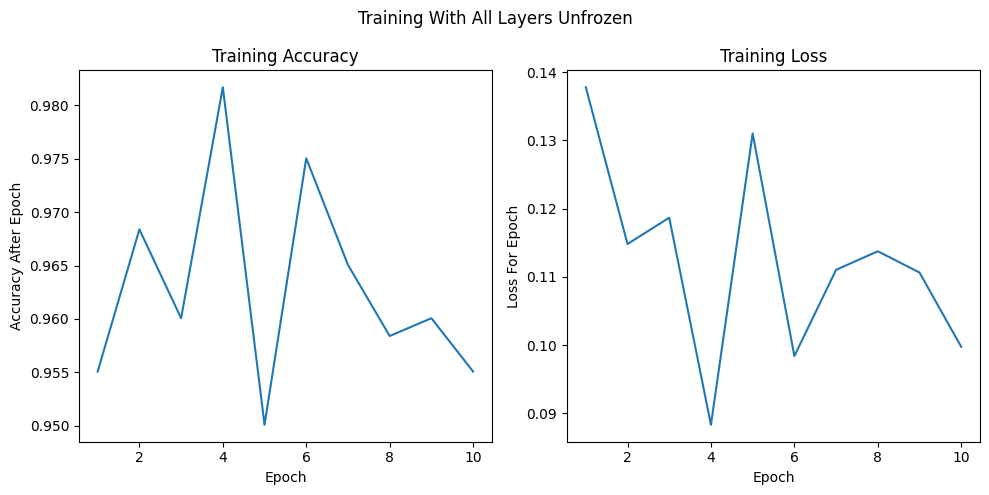

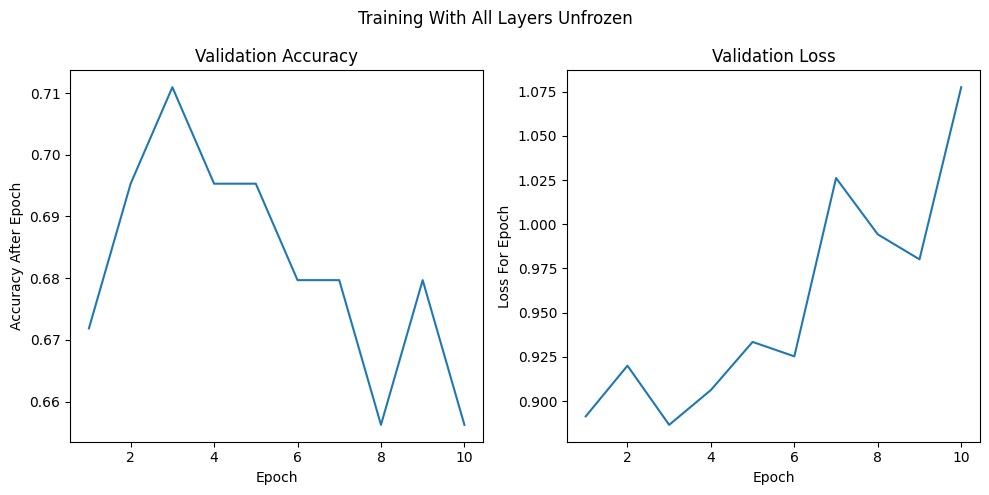

In [4]:
# This block fine-tunes input layer (sequential conv2D layer) of the model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # Lower learning rate from 1e-4 to 1e-5 as learning plateaus

for param in model.parameters(): # Unfreeze all layers to capture all previously unfrozen layers and the final convolutional layer
    param.requires_grad = True

print("Training Model With All Layers Unfrozen:\n")

model, layer_train_acc, layer_train_losses, layer_val_acc, layer_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With All Layers Unfrozen"
plot_learning(num_epoch, layer_train_acc, layer_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer_val_acc, layer_val_losses, layer_description, dataset="val")

In [5]:
# This block performs analysis and comparisons using the final newly trained model

model.eval()

output_list = []
correct = 0
total = 0
loss_trained = 0
with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        outputs = model(waveforms)
        _, predicted = torch.max(outputs, 1)
        total+= labels_num.size(0)
        correct+= (predicted == labels_num).sum().item()
        output_list.append(outputs)
        loss = criter(outputs,labels_num)
        loss_trained += loss.item() * waveforms.size(0)
        

print("{}% Test Accuracy With Newly Trained Model".format(correct/total*100))
print("Test Set Loss of {} With Newly Trained Model".format(loss_trained))



74.61538461538461% Test Accuracy With Newly Trained Model
Test Set Loss of 87.07120925188065 With Newly Trained Model


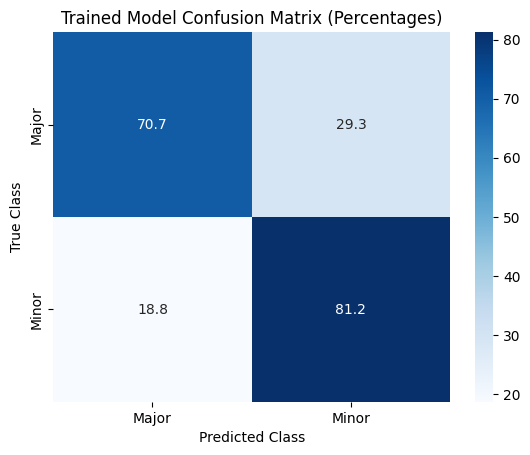

              precision    recall  f1-score   support

       Major       0.87      0.71      0.78        82
       Minor       0.62      0.81      0.70        48

    accuracy                           0.75       130
   macro avg       0.74      0.76      0.74       130
weighted avg       0.77      0.75      0.75       130



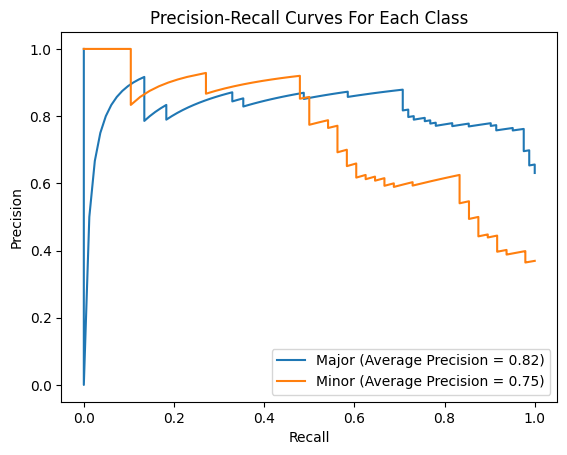

In [6]:
# This block generates the confusion matrix, classification report, and plots the PR curves for each class

from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score

model.eval()

class_names = ["Major", "Minor"]

label_prob = [] # list of all predicted classes probabilities
label_true = [] # list of true class labels
label_pred = [] # list of predicted class labels

with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        outputs = model(waveforms)
        probability = torch.softmax(outputs, dim = 1)
        _, pred = torch.max(outputs,1)
        #label_pred.extend(pred.cpu().numpy())
        #label_prob.extend(probability.cpu().numpy())
        #label_true.extend(labels.cpu().numpy())

        label_pred.extend(pred)
        label_prob.extend(probability)
        label_true.extend(labels_num)

label_prob = np.array(label_prob)
label_true = np.array(label_true)
label_pred = np.array(label_pred)

model_confusion = confusion_matrix(label_true, label_pred)
model_confusion_percent = model_confusion.astype('float') / model_confusion.sum(axis=1)[:, np.newaxis] * 100

plt.figure()
sns.heatmap(model_confusion_percent, cmap="Blues", annot=True, fmt = '.1f', xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Trained Model Confusion Matrix (Percentages)")
plt.show()

cr = classification_report(label_true, label_pred, target_names = class_names)
print(cr)

label_true_arr = np.eye(len(class_names))[label_true]

plt.figure()
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(label_true_arr[:,i], label_prob[:,i])
    average_precision = average_precision_score(label_true_arr[:,i], label_prob[:,i])

    
    plt.plot(recall, precision, label = "{} (Average Precision = {:.2f})".format(class_name, average_precision))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves For Each Class")
plt.legend()
plt.show()